# Demo - Adversarial Robustness

Reference: [get_started_pytorch.py](https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/get_started_pytorch.py)

In [1]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 983kB 7.4MB/s 
     |████████████████████████████████| 3.4MB 36.9MB/s 
     |████████████████████████████████| 25.3MB 121kB/s 
  Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

## Main

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from art.attacks.evasion import DeepFool, FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

%matplotlib inline

def plot_single_sample(image, title=""):
    plt.imshow(image, cmap="gray")
    plt.clim(0, 1)
    plt.axis("off")
    plt.title(title)
    plt.show()


def plot_samples(data, labels, Nr=3, Nc=3, figsize=(6, 6), cmap="gray"):
    fig, axs = plt.subplots(Nr, Nc, figsize=figsize)
    for i in range(Nr * Nc):
        try:
            image = data[i]
            title = f"Prediction: {labels[i]}"
        except IndexError:
            image = np.ones((8, 8))
            title = ""

        ax = axs[i // Nc][i % Nc]
        ip = ax.imshow(image, cmap=cmap)
        ip.set_clim(0, 1)
        ax.axis("off")
        ax.set_title(title)
    plt.show()

In [3]:
print(f"Pytorch Version: {torch.__version__}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.device_count() > 0:
    print(f"Found GPU at: {torch.cuda.get_device_name(0)}")

Pytorch Version: 1.8.1+cu101
Device: cuda
Found GPU at: Tesla T4


In [4]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Swap axes to PyTorch's NCHW format
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

In [5]:
# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [6]:
# Train classifier
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

In [7]:
# Evaluate the classifier on benign test examples
preds = np.argmax(classifier.predict(x_test), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Classifier before adversarial training")
print(f"Accuracy on benign test examples: {acc * 100:.2f}%")

Classifier before adversarial training
Accuracy on benign test examples: 97.86%


Original test examples


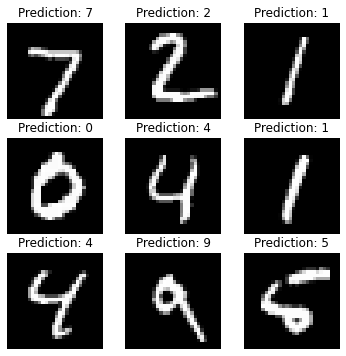

In [8]:
print("Original test examples")
plot_samples(x_test[:9, 0], preds[:9])

## Create adversarial samples

In [9]:
# Craft adversarial samples
# adv_crafter = DeepFool(classifier)
adv_crafter = FastGradientMethod(estimator=classifier, eps=0.2)
print("Craft attack test examples")
x_test_adv = adv_crafter.generate(x_test)

Craft attack test examples


In [10]:
# Evaluate the classifier on the adversarial samples
preds = np.argmax(classifier.predict(x_test_adv), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Classifier before adversarial training")
print(f"Accuracy on adversarial samples: {acc * 100:.2f}%")

Classifier before adversarial training
Accuracy on adversarial samples: 25.22%


Generated adversarial test examples


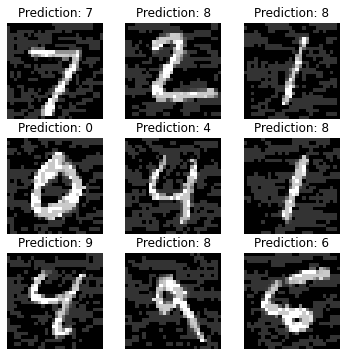

In [11]:
print("Generated adversarial test examples")
plot_samples(x_test_adv[:9, 0], preds[:9])

## Retraining with adversarial samples

In [12]:
print("Craft attack on training examples")
x_train_adv = adv_crafter.generate(x_train)

Craft attack on training examples


In [13]:
# Data augmentation: expand the training set with the adversarial samples
x_train = np.append(x_train, x_train_adv, axis=0)
y_train = np.append(y_train, y_train, axis=0)

# Shuffle training set
n_train = len(y_train)
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [14]:
is_poison_train = np.array([0] * len(x_train_adv) + [1] * len(x_train_adv))
is_poison_train = is_poison_train[shuffled_indices]

In [15]:
# Retrain classifier on the extended dataset
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

In [16]:
# Evaluate the classifier on benign test examples
preds = np.argmax(classifier.predict(x_test), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Classifier with adversarial training")
print(f"Accuracy on benign test examples: {acc * 100:.2f}%")

Classifier with adversarial training
Accuracy on benign test examples: 98.11%


In [17]:
# Evaluate the adversarially trained classifier on the adversarial samples
preds = np.argmax(classifier.predict(x_test_adv), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Classifier with adversarial training")
print(f"Accuracy on adversarial samples: {acc * 100:.2f}%")

Classifier with adversarial training
Accuracy on adversarial samples: 97.15%


Generated adversarial test examples


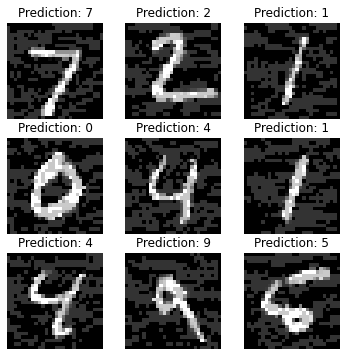

In [18]:
print("Generated adversarial test examples")
plot_samples(x_test_adv[:9, 0], preds[:9])